In [ ]:
import time
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn import metrics
from scipy import stats
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

In [160]:
def calcprecall(cf):
    classes = cf.shape[0]
    TP = np.diag(cf)
    FP = np.sum(cf, axis=0) - TP
    FN = np.sum(cf, axis=1) - TP

    accuracy = np.trace(cf)/(np.sum(np.sum(cf)))*100
    precision = (np.sum(TP / (TP + FP))/classes)*100
    recall = (np.sum(TP / (TP + FN))/classes)*100
    F1score = (2*precision*recall)/(precision+recall)    
    return accuracy, precision, recall, F1score

def draw_roc_curve(y_test,classes,classifier):
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    y_test = y_test.reshape(y_test.shape[0],n_classes)
    y_score = y_score.reshape(y_test.shape[0],n_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    ys = [1 for i in range(classes)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    for i  in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

## Following code will filter out the noisy samples 

In [158]:
alpha = 1/1.2
tdata = np.loadtxt("punjab_data.txt")

X = tdata[:,0:15]
Y = tdata[:,15]
m = X.shape[0]
n = X.shape[1]
skf = StratifiedKFold(n_splits=10)
classes = 9
# initializing confusion matrix to zero
CfGNB =np.zeros((classes,classes))

# matrix to store probability distribution of each sample for "classes" 
probs = np.array([]).reshape(0,classes)

# matrix to store log probability distribution of each sample for "classes" 
logprobs = np.array([]).reshape(0,classes)

# matrix to store entropy of each sample
entropy = np.array([]).reshape(0,1)

# theses matrices would include all samples and their corresponding values in the order as selected by skf
Xkf = np.array([]).reshape(0,n)
Ykf = np.array([]).reshape(0,1)
YNewkf = np.array([]).reshape(0,1)
pgnb = np.array([]).reshape(0,1)

names = ['B1','B2', 'B3', 'B4', 'B5', 'B6','B7','B8','B8A','B9','B10','B11', 'B12','VH','VV'];

for train_index, test_index in skf.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    m_test = X_test.shape[0]
    
#   copy y_test to y_tes_new
    y_test_new  = np.copy(y_test)
    
#   training and testing with baysian
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictGNB = gnb.predict(X_test)
    p = gnb.predict_proba(X_test)                       # probability distributions for all samples in test set
    logp = gnb.predict_log_proba(X_test)                # lop of probability distributions for all samples in test set
    D = -np.sum(p*logp,axis=1).reshape(m_test,1)        # entropy
    
    cf = confusion_matrix(y_test, predictGNB)
    CfGNB = CfGNB + cf
    
#   concatenating probability ditributions, their logs, and entropies for each of n test sets  
    probs = np.concatenate([probs,p])
    logprobs = np.concatenate([logprobs,logp])
    entropy = np.concatenate([entropy,D])
    
#   concatenating Xtest, Ytest, YtestNew, preidctions for each of n test sets
    Xkf = np.concatenate([Xkf,X_test])
    Ykf = np.concatenate([Ykf,y_test.reshape(m_test,1)])
    YNewkf = np.concatenate([YNewkf,y_test_new.reshape(m_test,1)])
    pgnb = np.concatenate([pgnb,predictGNB.reshape(m_test,1)])
    
print(CfGNB)
[acc3, pre3, rec3, f3] = calcprecall(CfGNB)
print("GNB:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc3,pre3,rec3,f3))

# sort entropy array in ascending order 
indexArraySorted = np.argsort(np.squeeze(entropy))

index = int(alpha*(m))

# T is threshold for entropy, samples having larger entropy than T are noisy samples
# entropy lower than T means probability corresponding to one of n classes is significantly
# greater than others and sample is typical one

T = entropy[indexArraySorted[index]]
print(T)
print(probs[indexArraySorted[index]])
print(logprobs[indexArraySorted[index]])

# relabeling the samples where entropy < T and has not been predicted as the original label
check1 = np.where((entropy<T)&(pgnb!=Ykf))[0]
YNewkf[check1]=pgnb[check1]
print("number of labels updated: {}".format(np.sum(YNewkf!=Ykf)))

# keep only those samples which are not noisy i.e. their entropy < threshold
filteredIndices = np.where(entropy<T)[0]
filteredX = np.take(Xkf, filteredIndices, axis = 0)
filteredY = np.take(YNewkf,filteredIndices).reshape(filteredX.shape[0],1)
filteredData = np.concatenate([filteredX,filteredY],axis = 1)
print(filteredData.shape)


print("land: {}".format(np.sum(filteredY == 0)))
print("fallow: {}".format(np.sum(filteredY == 1)))
print("water: {}".format(np.sum(filteredY == 2)))
print("fodder: {}".format(np.sum(filteredY == 3)))
print("wheat: {}".format(np.sum(filteredY == 4)))
print("gram: {}".format(np.sum(filteredY == 5)))
print("maize: {}".format(np.sum(filteredY == 6)))
print("vegetable: {}".format(np.sum(filteredY == 7)))
print("trees: {}".format(np.sum(filteredY == 8)))

# sorting all the filtered data in the order of labels from 0 to classes-1
filteredData = filteredData[filteredData[:,15].argsort()]


# concatenate whole data concatenated for each of n test sets
# sort it in the order of "original labels" from 0 to classes-1
# save it to csv file
wholeData = np.concatenate([Xkf,Ykf,YNewkf,pgnb,entropy],axis = 1)
wholeData = wholeData[wholeData[:,15].argsort()]
np.savetxt("data_baysian.csv", wholeData, delimiter=",",fmt='%1.3f',header="B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,VV,VH,Y,Y_new,predictions, entropy")

[[50.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 27.  5.  3.  6.  1.  8.]
 [ 0.  0.  0.  1. 23.  5. 10.  4.  7.]
 [ 0.  0.  0.  1.  1. 45.  2.  0.  1.]
 [ 0.  0.  0.  0.  4.  0. 35.  6.  5.]
 [ 0.  0.  0.  8. 11.  0. 13. 12.  6.]
 [ 0.  0.  0.  9. 11.  3. 19.  1.  7.]]
GNB:
 accuracy = 66.44444444444444, precision = 65.84840919239896, recall = 66.44444444444444, f1-score= 66.14508412298535
375
[0.76269726]
[0.00000000e+000 0.00000000e+000 1.09698319e-105 1.75695081e-002
 7.66816951e-001 1.82097321e-008 1.54135832e-003 1.12218415e-001
 1.01853750e-001]
[-1.97260589e+06 -1.26792762e+06 -2.41678871e+02 -4.04159037e+00
 -2.65507162e-01 -1.78213097e+01 -6.47509122e+00 -2.18730817e+00
 -2.28421732e+00]
number of labels updated: 100
(375, 16)
land: 50
fallow: 50
water: 50
fodder: 37
wheat: 38
gram: 55
maize: 67
vegetable: 19
trees: 9


## Following code will perform startifiedKfoldValidation for filtered Data

In [159]:
m = filteredData.shape[0]
subsets = 10
classes = 9
a = m

# discarding classes for which total number of samples < subsets
for i in range(1,classes):
    c = np.sum(filteredY == i)
    if(c < subsets):
        a = a - c
        classes = classes - 1
        print("{} th class rejected due to lower number of samples".format(i))


X = filteredData[0:a,0:15]
Y = filteredData[0:a,15]
skf = StratifiedKFold(n_splits=subsets)
Y = Y.reshape(X.shape[0],)
CfGNB =np.zeros(classes)
names = ['B1','B2', 'B3', 'B4', 'B5', 'B6','B7','B8','B8A','B9','B10','B11', 'B12','VH','VV'];

for train_index, test_index in skf.split(X,Y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # training and testing with baysian
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictGNB = gnb.predict(X_test)
    cf = confusion_matrix(y_test, predictGNB)
    CfGNB = CfGNB + cf

print(CfGNB)
[acc3, pre3, rec3, f3] = calcprecall(CfGNB)
print("GNB:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc3,pre3,rec3,f3))

8 th class rejected due to lower number of samples
[[50.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 35.  0.  0.  0.  2.]
 [ 0.  0.  0.  0. 30.  2.  4.  2.]
 [ 0.  0.  0.  0.  4. 50.  0.  1.]
 [ 0.  0.  0.  4.  0.  0. 62.  1.]
 [ 0.  0.  0.  0.  3.  2.  2. 12.]]
GNB:
 accuracy = 92.62295081967213, precision = 90.15755008402067, recall = 90.01828276180201, f1-score= 90.08786259941367


## SPLIT filtered data and calculate its accuracy, precision, recall and f1 score

In [152]:
X = filteredData[:,0:15]
Y = filteredData[:,15]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictGNB = gnb.predict(X_test)
CfGNB = confusion_matrix(y_test, predictGNB)

print(CfGNB)
[acc3, pre3, rec3, f3] = calcprecall(CfGNB)
print("GNB:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc3,pre3,rec3,f3))

[[20  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  1  1]
 [ 0  0  0  0  9  1  1  1  0]
 [ 0  0  0  0  1 14  0  0  0]
 [ 0  0  0  0  0  0 20  1  0]
 [ 0  0  0  1  0  0  1  4  0]
 [ 0  0  0  0  0  0  1  0  2]]
GNB:
 accuracy = 91.93548387096774, precision = 87.22316331011983, recall = 86.6931216931217, f1-score= 86.9573348023425


## Draw ROC curves for different algorithms (using filtered data)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.

<IPython.core.display.Javascript object>


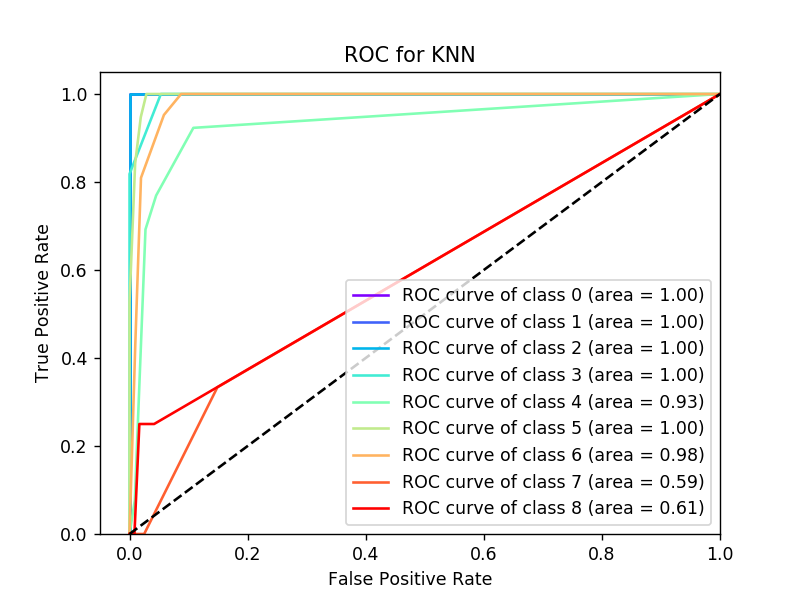

<IPython.core.display.Javascript object>


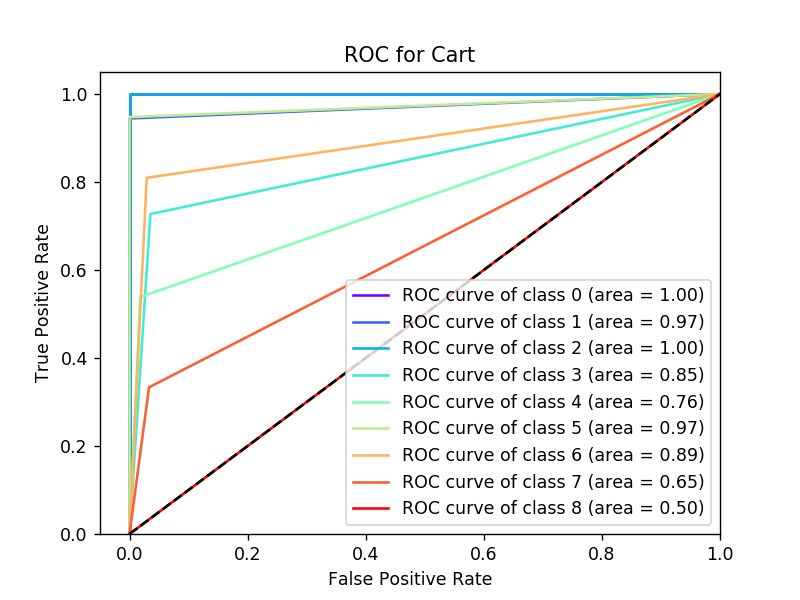

<IPython.core.display.Javascript object>


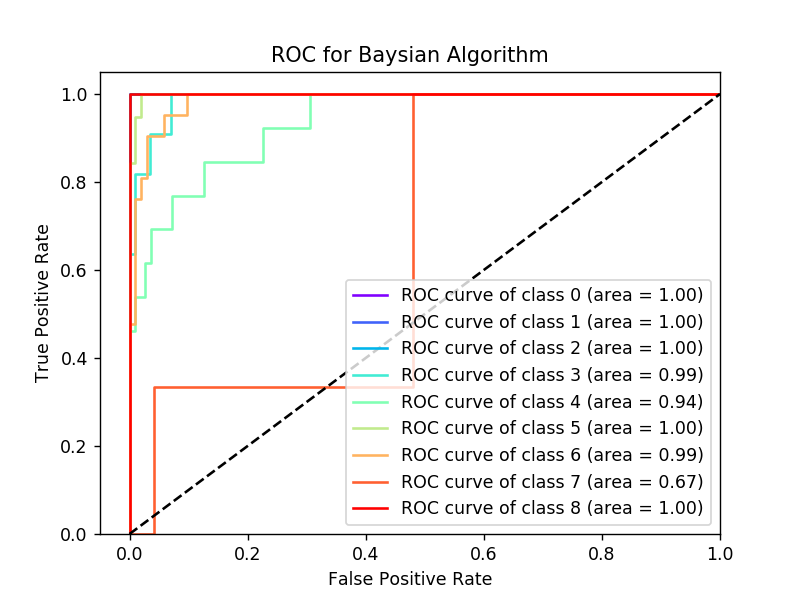

<IPython.core.display.Javascript object>


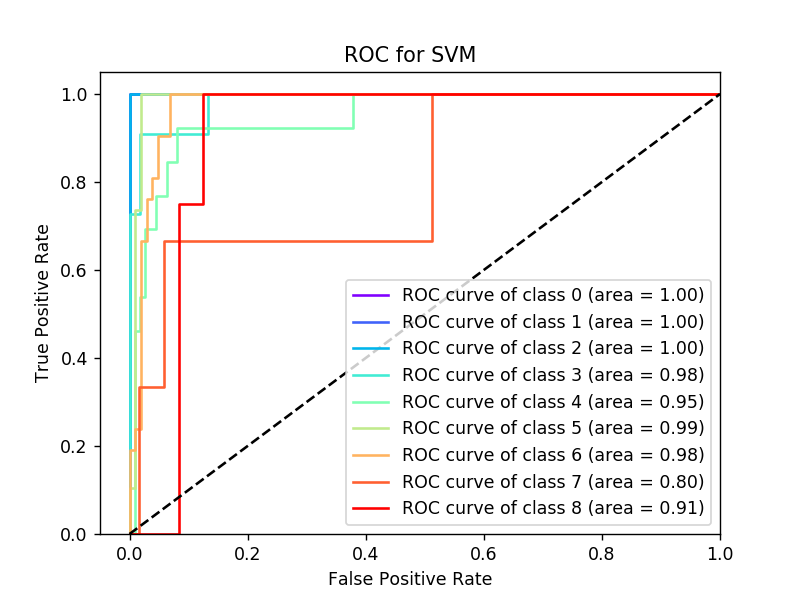

<IPython.core.display.Javascript object>


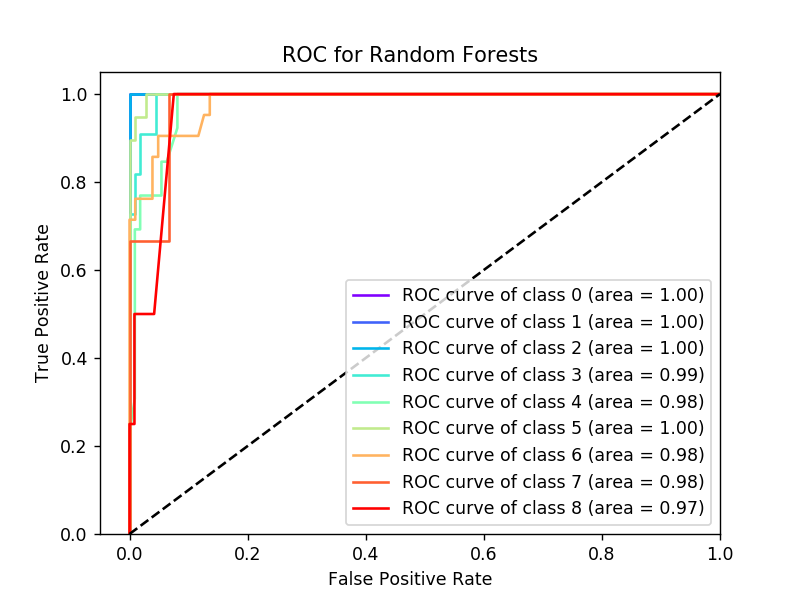

Text(0.5, 1.0, 'ROC for Random Forests')

In [154]:
X = filteredData[:,0:15]
Y = filteredData[:,15]
print(Y)
n_classes = int(max(Y)+1)
print(n_classes)
c = np.linspace(start = 0, stop = n_classes-1, num=n_classes)
print(c)
# Binarize the output
y = label_binarize(Y, classes=c)

n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=0)

plt.figure(0)
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
draw_roc_curve(y_test,n_classes,knn)
plt.title('ROC for KNN')

plt.figure(1)
knn = OneVsRestClassifier(DecisionTreeClassifier())
draw_roc_curve(y_test,n_classes,knn)
plt.title('ROC for Cart')

plt.figure(2)
gnb = OneVsRestClassifier(GaussianNB())
draw_roc_curve(y_test,n_classes,gnb)
plt.title('ROC for Baysian Algorithm')

plt.figure(3)
knn = OneVsRestClassifier(SVC(kernel='rbf',gamma='scale',probability=True))
draw_roc_curve(y_test,n_classes,knn)
plt.title('ROC for SVM')

plt.figure(4)
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
draw_roc_curve(y_test,n_classes,rf)
plt.title('ROC for Random Forests')

